<a href="https://colab.research.google.com/github/alex160798/module_8/blob/main/%22%5BSF%5D_Car_classification%221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# О данном ноутбуке

Этот ноутбук - введение в проект [Ford vs Ferrari](https://www.kaggle.com/c/sf-dl-car-classification) и бейзлайн (базовое решение) по этому проекту.

Автор проекта: Алекс Леков



Цели проекта:
*   изучить реальную задачу компьютерного зрения на практике (можно будет добавить в портфолио)
*   продолжать учиться программировать: с каждым днем практики ваш код становится лучше, а вы становитесь опытнее

Автор данного бейзлайна и проверяющий ментор: Олег Зяблов

Также можете посмотреть [бейзлайн от Алекса Лекова](https://www.kaggle.com/itslek/baseline-keras-xception-car-class-v2-0)

# Версия 1

## История изменений:
 - Установили ImageDataAugmenter и заменили им ImageDataGenerator (Версия 1). Получили val_accuracy 0.69, что немного выше baseline

In [ ]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-85tf0vyl
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-85tf0vyl
     |████████████████████████████████| 49.9 MB 16 kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29545 sha256=d84e8ddd74803d7f1d4f94547eb1684e4824a11497cc0049c8c8f0d44e5c9901
  Stored in directory: /tmp/pip-ephem-wheel-cache-gww560e7/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2

In [ ]:
# проверяем, что видеокарта подключена
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c227452e-764b-a512-27f1-35469542c6e2)


In [ ]:
# подготавливаем данные

# для Google Colab:
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'
train_path = '/content/train/'
sub_path = '/content/test_upload/'

# для Kaggle Kernel
# !mkdir /kaggle/temp #папка для временных файлов
# !unzip /kaggle/input/train.zip -d /kaggle/temp
# !unzip /kaggle/input/test.zip -d /kaggle/temp
# sample_submission_path = '/kaggle/input/sample-submission.csv'
# train_path = '/kaggle/temp/train/'
# sub_path = '/kaggle/temp/test_upload/'
# %cd /kaggle/working  #переходим в рабочую директорию

#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
/ [1 files][  1.6 GiB/  1.6 GiB]   37.6 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
replace sf-dl-car-classification/sample-submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sf-dl-car-classification/sample-submission.csv  
replace sf-dl-car-classification/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sf-dl-car-classification/train.csv  
replace sf-dl-car-classification/test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: sf-dl-car-classification/test.zip  
replace sf-dl-car-classification/train.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: sf-dl-car-classification/train.zip  


In [ ]:
# импорты

import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
import tensorflow.keras.backend as K

from ImageDataAugmentor.image_data_augmentor import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

**Как будем делить данные?**

Мы имеем обучающий датасет и датасет для сабмита (тестовый). Количество сабмитов ограничено 5 в сутки, поэтому перед сабмитом нужно как-то оценить модель, чтобы следить за переобучением и не сабмитить заранее проигрышные решения. Для этого от обучающего датасета мы отделяем валидационный.

Мы можем поделить данные например в таком соотношении:

*   **train** - 80% обучающих изображений
*   **val** (валидационный датасет) - 20% обучающих изображений
*   **sub** (submission) - тестовые изображения для сабмита, к которым не дано ответов

**Создаем генераторы изображений**

In [ ]:
transform = A.Compose([
    #A.CLAHE(),
    #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    #A.Blur(blur_limit=3),
    #.OpticalDistortion(),
    #A.GridDistortion(),
    #A.HueSaturationValue(),
    # Версия 1

    #A.Flip(p=0.5),
    #A.OneOf([
        #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        #A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    #],p=1),
    #A.GaussNoise(p=0.05),
    #A.HueSaturationValue(p=0.5),
    #A.RGBShift(p=0.5),
    # Версия 1.1

    #A.Flip(p=0.5)
    # Версия 1.2

    #A.Flip(p=0.5),
    #A.HueSaturationValue(p=0.5)
    # Версия 1.3

    A.Flip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5)
    # Версия 1.4
])

In [ ]:
image_size = (90, 120)
batch_size = 32

train_datagen = ImageDataAugmentor(
    #rescale=1/255, 
    preprocess_input=None,
    augment=transform
)

val_datagen = ImageDataAugmentor(
    #rescale=1/255,
    validation_split=0.2,
)

sub_datagen = ImageDataAugmentor(
    #rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
    )

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 15561 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Сначала мы создали объекты ImageDataGenerator, указав, какие преобразования выполнять с изображениями. Затем мы указали откуда брать изображения.

В итоге мы получили генераторы - это [итерируемые python-объекты](https://pythonz.net/references/named/iterable/).

Обратите внимание, что строка `#rescale=1/255` закомментирована. Это означает, что генераторы выдают изображения с яркостью цветовых каналов пикселя от 0 до 255. Дальнейшие действия зависят от того, какую нейронную сеть вы будете использовать, например:
*    EfficientNetB0, которая используется в бейзлайне, не требует нормализации (нормализация встроена в саму модель)
*    Xception требует нормализацию, поэтому нужно либо раскомментировать строку `#rescale=1/255`, либо встроить нормализацию в модель, добавив например такой слой: `Lamba(lambda x: x/255)`

Train:


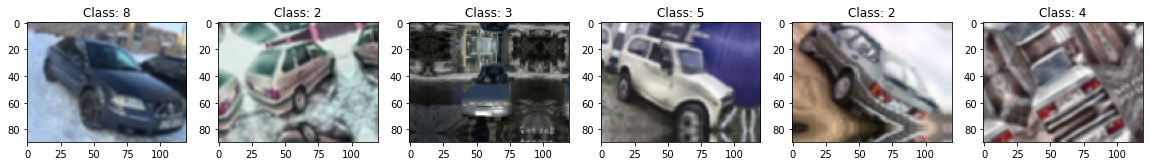

Val:


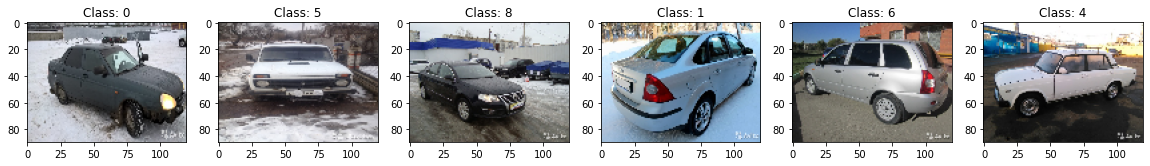

Sub:


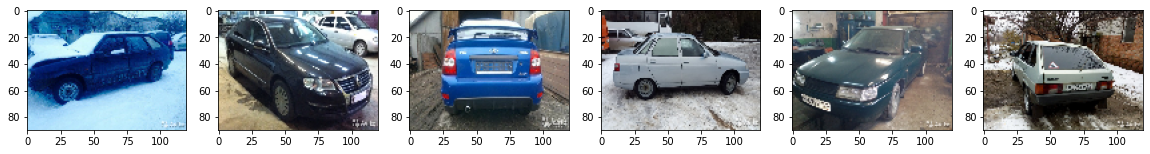

In [ ]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

In [ ]:
# строим модель
model = Sequential([
  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy'
)

In [ ]:
K.clear_session()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 3, 4, 1280)        4049571   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,381
Trainable params: 4,020,358
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
# обучаем модель
model.fit(train_generator, validation_data=val_generator, epochs=1)

487/487 [==============================] - 143s 274ms/step - loss: 2.2351 - accuracy: 0.3571 - val_loss: 0.9386 - val_accuracy: 0.6571


 - Версия 1: val_accuracy 0.37
 - Версия 1.1: val_accuracy 0.58
 - Версия 1.2: val_accuracy 0.69
 - Версия 1.3: val_accuracy 0.69
 - Версия 1.3: val_accuracy 0.66

Что мы получили в итоге?

*   Точность на обучающих данных, усредненная по первой эпохе, равна 0.4
*   Точность на валидационных данных в конце первой эпохи равна 0.6

Сделаем файл для сабмита:

In [ ]:
predictions = model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)

209/209 [==============================] - 30s 139ms/step


# Что дальше?

Предлагаемый план действий:
1.    Разберите код бейзлайна
1.    Создайте копию ноутбука, удалите все лишнее и оставьте только код
1.    Ищите способы улучшить решение и повысить точность

Рекомендации о том, как повысить точность
*   Обучайте дольше и на большем разрешении
*   Пробуйте использовать другие модели и ансамбли
*   Сделайте больше аугментаций, но не чрезмерно (следите за точностью на валидации)
*   Управляйте learning rate
*   Измените соотношение размеров train/val датасетов
*   Используйте TTA (test-time augmentations)
*   Поищите в интернете обученные нейронные сети для работы с автомобилями
*   Скачайте из интернета дополнительные изображения для обучения
*   Смотрите ноутбуки с решениями других Kaggle-соревнований по CV


# Сниппеты кода

Сниппетом называется участок кода, демонстрирующий, как делать ту или иную вещь. Ниже приведен набор сниппетов для проекта Ford vs Ferrari, который может помочь вам улучшить базовое решение и повысить точность.

### Построение модели

Keras предоставляет возможность строить модель двумя способами: в последовательном и функциональном стиле. Сравните примеры ниже:

In [ ]:
model_1 = Sequential([
  Xception(include_top=False, input_shape=(150, 150, 3)),
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

###########################

base_model = Xception(include_top=False, input_shape=(150, 150, 3))
output = GlobalMaxPool2D()(base_model.output)
output = Dropout(0.5)(output)
output = Dense(10)(output)
model_2 = Model(inputs=base_model.input, outputs=output)

###########################

base_model = Xception(include_top=False, input_shape=(150, 150, 3))
head = Sequential([
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])
model_3 = Model(inputs=base_model.input, outputs=head(base_model.output))

###########################

base_model = Xception(include_top=False, input_shape=(150, 150, 3))
head = Sequential([
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])
model_4 = Sequential([
  base_model,
  head
])

83697664/83683744 [==============================] - 0s 0us/step


Все способы в итоге дают одну и ту же с вычислительной точки зрения архитерктуру модели. Но с программной точки зрения способы отличаются. Можно проверить, что `.summary()` по всем моделям дает разные результаты.

В **первом примере** сеть `Xception` является первым слоем модели: `model_1.layers[0]`. Представьте, что `model_1` - это коробка, в которой находится 3 слоя и еще одна коробка `Xception`, внутри которой уже находятся сверточные слои.

Во **втором примере** слоями `model_2` являются слои сети `Xception` и слои головы. Таким образом мы избавляемся от вложенной коробки.

В **третьем примере** слои сети `Xception` являются слоями модели `model_3`, но слои головы помещены в отдельную под-модель ("вложенную коробку").

В **четвертом примере** в модели всего 2 слоя - `Xception` и голова. Каждый из этих двух слоев в свою очередь является моделью, состоящей из набора слоев.

---------

Эти примеры показывают, что можно строить модель иерархично, когда слои сами являются моделями со вложенными слоями. Для работы над проектом **рекомендую использовать первый вариант** (`model_1`) как наиболее лаконичный и удобный.

Второй пример (`model_2`) называется построением модели в **функциональном стиле**, то есть мы вызываем модель как функцию, которая принимает объект `KerasTensor` и возвращает объект `KerasTensor`. Таким образом по шагам строится граф вычислений.

Лучше по возможности избегать функционального стиля, так как код получается сложнее, а значит больше шанс сделать ошибку и сложнее вносить изменения. Строить модель в функциональном стиле имеет смысл только если вы имеете разветвленный граф вычислений. Например сама сеть `Xception` имеет разветвленный граф вычислений, можете посмотреть ее [исходный код](https://github.com/tensorflow/tensorflow/blob/v2.5.0/tensorflow/python/keras/applications/xception.py#L46-L313).

--------

Напоследок рассмотрим пример того, как можно использовать функциональный стиль для построения разветвленного графа вычислений, где информация проходит сразу через две сверточные сети:

In [ ]:
image_size = (90, 120)

input = Input(shape=(*image_size, 3))
my_xception = Sequential([
  Lambda(lambda x: x/255), #не забудем нормализацию для Xception (в EfficientNetB0 она уже встроена)
  Xception(input_shape=(*image_size, 3), include_top=False),
  GlobalMaxPool2D()
])
my_efficientNet = Sequential([
  EfficientNetB0(input_shape=(*image_size, 3), include_top=False),
  GlobalMaxPool2D()
])
head = Sequential([
  Dropout(0.5),
  Dense(10)
])
output = head(Concatenate()([my_xception(input), my_efficientNet(input)]))
my_model = Model(inputs=input, outputs=output)

Обе модели возвращают тензор с 2 осями. Первая ось - номер примера в батче, вторая ось - номер признака. Иными словами - вектор для каждого изображения. Мы делаем конкатенацию этих тензоров по номеру признака, а затем пропускает результат через выходной полносвязный слой. Сразу проверим, что модель корректно работает:

1.   Принимает батч изображений размером (N, 90, 120, 3)
2.   Возвращает предсказание размером (N, 10)

In [ ]:
my_model(np.zeros((2, 90, 120, 3))).numpy().shape

(2, 10)

Обычно такие "модели-мутанты" не используют, но вы можете попробовать. Вдруг сработает?

Важно!
1. Если вызвать модель как функцию, передав ей numpy-массив, то результатом ее работы будет объект `tf.EagerTensor`. Его можно перевести в numpy, как это сделано выше. При этом в модель можно передать дополнительный параметр training - режим работы модели (обучение или инференс). Например dropout не будет применен при инференсе.
2. Если вызвать метод predict модели, передав numpy-массив, то результатом будет numpy-массив, при этом модель сработает в режиме инференса.

### Выходной слой модели

Текущий проект является задачей классификации со взаимоисключающими классами. Давайте рассмотрим два варианта построения выходного слоя и функции потерь модели:

In [ ]:
model_1 = Sequential([
  Xception(include_top=False, input_shape=(150, 150, 3)),
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

model_1.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam')

###########################

model_2 = Sequential([
  Xception(include_top=False, input_shape=(150, 150, 3)),
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10, 'softmax')
])

model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

Оба способа практически эквивалентны.

В параметры loss, optimizer, metrics функции compile можно передавать либо строки, либо объекты. Если передана строка (как во 2-м случае с loss и в обоих случаях с optimizer), то keras будет искать по названию среди известных ему loss'ов и optimizer'ов.

Первый вариант работает несколько стабильнее в плане точности вычислений. О том, почему это так, можно почитать [здесь](https://stackoverflow.com/questions/61233425/what-should-i-use-as-target-vector-when-i-use-binarycrossentropyfrom-logits-tru/61237426#61237426). Если кратко, то суть в том, что softmax использует экспоненту, а кроссэнтропия - логарифм. Если взять экспоненту а затем логарифм от некоего очень большого/маленького числа, то можно получить бесконечность/ноль из-за погрешности вычислений. Параметр `from_logits=True` и отсутствие `softmax` в выходном слое избавляют от этой проблемы.

### Сохранение и загрузка моделей

Вы можете сохранить и загрузить модель из файла следующим кодом:

In [ ]:
model.save('model.h5') #сохранение
model = keras.models.load_model('model.h5') #загрузка

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Можно также загрузить в уже созданную модель веса из файла (`model.load_weights`), но обычно это не требуется.

Расширения `.h5` и `.hdf5` эквивалентны и означают один и тот же формат файла - Hierarchical Data Format версии 5.

Иногда после загрузки модели она некорректно работает (например начинает выдавать один и тот же ответ при любых входных данных), поэтому после загрузки модели стоит ее заново скомпилировать. Модель сохраняется вместе с оптимизатором, но при перекомпиляции внутреннее состояние оптимизатора будет утеряно. Обычно это не является проблемой.

### Коллбэки

Метод `.fit()` принимает параметр callbacks. Это означает задание неких действий, которые будут выполнены после каждой эпохи или шага обучения. Давайте рассмотрим какие могут быть коллбэки и зачем они нужны.

In [ ]:
from tensorflow.keras.callbacks import *

In [ ]:
ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                verbose=1, mode='max', save_best_only=True)

Этот коллбэк сохраняет модель в файл best_model.h5 (в текущей рабочей директории) в том случае, если значение val_accuracy после текущей эпохи достигло максимума.

Например, после первых 5 эпох точность росла, а в течение следующих 5 эпох падала. Загрузив модель из файла `best_model.h5` вы вернете состояние модели после первых 5 эпох, когда точность стала максимальной:

`model = keras.models.load_model('best_model.h5')`

In [ ]:
EarlyStopping(monitor='val_loss', patience=5)

Этот коллбэк прекращает обучение модели, если val_loss не падает в течение 5 эпох. Это может говорить о переобучении либо о стагнации процесса обучения. Читайте подробнее в [документации](https://keras.io/api/callbacks/early_stopping/).

Совет: не торопитесь прекращать обучение, если метрика качества перестала расти. Приведу следующую цитату ([источник](http://karpathy.github.io/2019/04/25/recipe/)):

*Leave it training. I’ve often seen people tempted to stop the model training when the validation loss seems to be leveling off. In my experience networks keep training for unintuitively long time. One time I accidentally left a model training during the winter break and when I got back in January it was SOTA (“state of the art”).*

In [ ]:
TerminateOnNaN()

Прекращает обучение, если loss стал равным NaN. Почему это может происходить можно почитать например [здесь](https://stackoverflow.com/questions/40050397/deep-learning-nan-loss-reasons). Среди самых очевидных причин:

1.   Слишком высокий learning rate
2.   Отсутствие нормализации
3.   NaN в исходных данных
4.   Ошибки в архитектуре сети

In [ ]:
LambdaCallback(on_epoch_end=lambda epoch, logs:
               print(f'Epoch {epoch} ended... Should we do something?'))

`LambdaCallback` позволяет задать действия после конца эпохи или шага обучения, а также и в другие моменты (см. [документацию](https://keras.io/api/callbacks/lambda_callback/))

In [ ]:
ReduceLROnPlateau()

Уменьшает learning rate в те моменты, когда начинает наблюдаться стагнация процесса обучения, то есть выбранная метрика (по умолчанию val_loss) не улучшается в течение нескольких эпох. Читайте подробнее в [документации](https://keras.io/api/callbacks/reduce_lr_on_plateau/).

### Управление learning rate

В качестве альтернативы `ReduceLROnPlateau` вы можете плавно уменьшать learning rate от шага к шагу обучения, используя такие объекты как `ExponentialDecay`, `InverseTimeDecay` или `PiecewiseConstantDecay`. Пример:

In [ ]:
from tensorflow.keras.optimizers.schedules import *
lr = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(lr)

Внимательно подбирайте параметры для `ExponentialDecay` (экспоненциального затухания). Слишком быстрое затухание может не дать сети успеть обучиться, а слишком медлленное просто не иметь эффекта при небольшом количестве эпох.

Обратите внимание! Параметр `decay_steps` в `ExponentialDecay` означает не количество эпох, а количество шагов (батчей).

Читайте подробнее в [документации](https://keras.io/api/optimizers/learning_rate_schedules/).

### Аугментации

При обучении мы каждый раз "показываем" сети немного разные варианты одной и той же картинки. Обучение с аугментациями данных - это один из способов регуляризации (повышения обобщающей способности модели).

**Пример 1**. Аугментации с помощью ImageDataGenerator:

In [ ]:
my_datagen = ImageDataGenerator(
    horizontal_flip=True, #отражение по горизонтали с вероятностью 50%
    rotation_range=10, #случайный поворот в пределах 10 градусов
    shear_range=0.2, #случайный сдвиг с искажением
    brightness_range=(0.8, 1.2), #случайное изменение яркости
    #...
)

**Пример 2**. Аугментации с помощью библиотеки albumentations:

In [ ]:
!pip install albumentations -q -U

     |████████████████████████████████| 98 kB 5.8 MB/s 
     |████████████████████████████████| 37.1 MB 82 kB/s 


Found 15561 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


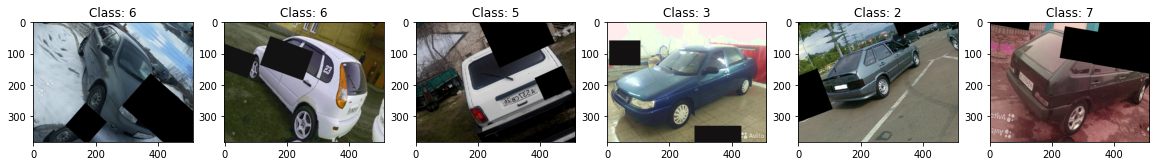

Found 15561 images belonging to 10 classes.


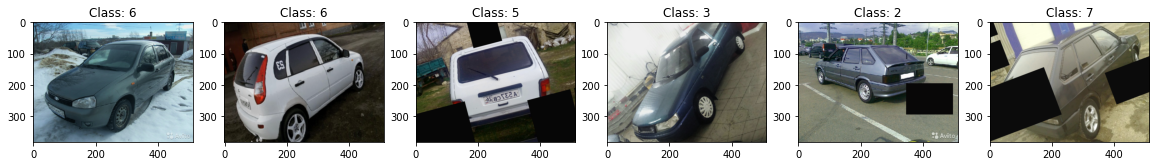

Found 15561 images belonging to 10 classes.


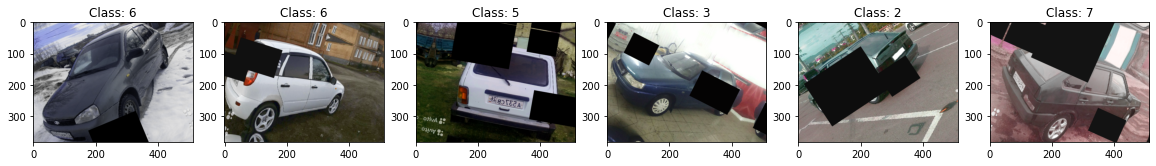

In [ ]:
import albumentations as A

def augment(image):
  image = image.astype(np.uint8)
  aug = A.Compose([
      A.Cutout(p=0.5, num_holes=1, max_h_size=150, max_w_size=200),
      A.Cutout(p=0.5, num_holes=1, max_h_size=100, max_w_size=150), #второй раз
      A.Cutout(p=0.5, num_holes=1, max_h_size=80, max_w_size=100), #третий раз
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(p=0.7),
      A.HueSaturationValue(p=1),
      # Читайте документацию прежде чем копировать и использовать этот код!
      # https://albumentations.ai/docs/api_reference/augmentations/transforms/
      # https://albumentations.ai/docs/examples/example/
      # Данный набор аугментаций - лишь пример
      # Подумайте сами как будет лучше, почитайте статьи в интернете по этой теме
  ])
  return aug(image=image)['image']

my_datagen = ImageDataGenerator(
    preprocessing_function=augment
)

for _ in range(3):
  my_generator = my_datagen.flow_from_directory(
      train_path,
      target_size=(384, 512),
      batch_size=1,
      shuffle=True,
      seed=0
  )
  show_first_images(my_generator)

**Пример 3**. Аугментации с помощью слоев keras ([preprocessing layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)).

Эти аугментации выполняются на GPU, что намного быстрее albumentations, который не использует GPU. Однако набор доступных аугментаций меньше. Для расширения набора доступных аугментаций можно использовать tensorflow_addons.

Еще один плюс - такие аугментации можно использовать на TPU.

In [ ]:
!pip install tensorflow_addons -q
import tensorflow_addons as tfa

     |████████████████████████████████| 679 kB 6.8 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Found 12452 images belonging to 10 classes.


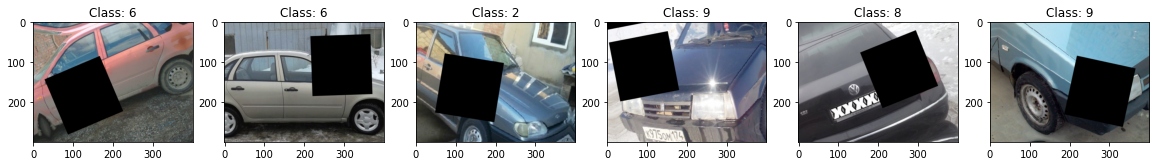

Found 12452 images belonging to 10 classes.


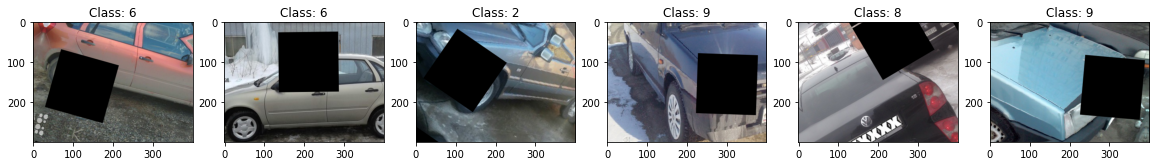

Found 12452 images belonging to 10 classes.


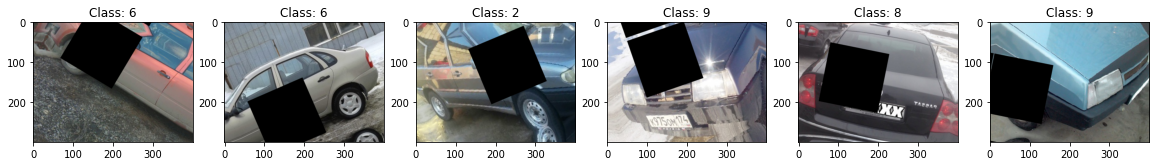

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import *
preprocessing_model = Sequential([
  RandomCrop(300, 400),
  RandomFlip(mode='horizontal'),
  Lambda(lambda images: tfa.image.random_cutout(images, (150, 150))),
  RandomRotation(0.1),
])

my_model = Sequential([
  preprocessing_model,
  EfficientNetB0(weights='imagenet', input_shape=(300, 400, 3), include_top=False),
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

train_datagen = ImageDataGenerator(validation_split=0.2)

for _ in range(3):
  train_generator = train_datagen.flow_from_directory(
      train_path,
      target_size=(450, 600),
      batch_size=1,
      class_mode='categorical',
      shuffle=True,
      seed=0,
      subset='training'
  )
  
  def augment_batch_to_visualize(X, y):
    return preprocessing_model(X, training=True).numpy(), y
  
  show_first_images((augment_batch_to_visualize(X, y) for X, y in train_generator))

Важно! слои из `tensorflow.keras.layers.experimental.preprocessing` имеют эффект только в режиме обучения, однако слой 

`Lambda(lambda images: tfa.image.random_cutout(images, (100, 100)))`

работает также в режиме инференса.

Советы:
1. Всегда смотрите визуально что получается когда вы делаете аугментации
2. Измерьте время, затрачиваемое на аугментации. Сравните его со временем, затрачиваемым на обучение. Если больше 70% времени вычислений тратится на аугментации, то может быть стоит их уменьшить?
3. Не делайте слишком сильные аугментации, так как это может привести к падению качества обучения.
4. Используйте аугментации на данных для сабмита (почитайте про test-time augmentations - [1](https://machinelearningmastery.com/how-to-use-test-time-augmentation-to-improve-model-performance-for-image-classification/), [2](https://arxiv.org/abs/2011.11156))

### Test-time augmentations (TTA)

Этот термин означает применение аугментаций к изображениям при инференсе для улучшения качества предсказаний. Для каждого изображения мы получаем несколько предсказаний и усредняем их.

Как описано выше, есть разные способы делать аугментации:
1. Использование `ImageDataGenerator` (с albumentations или без). В этом случае сделаем генератор изображений для сабмита с аугментациями:

Found 6675 validated image filenames.


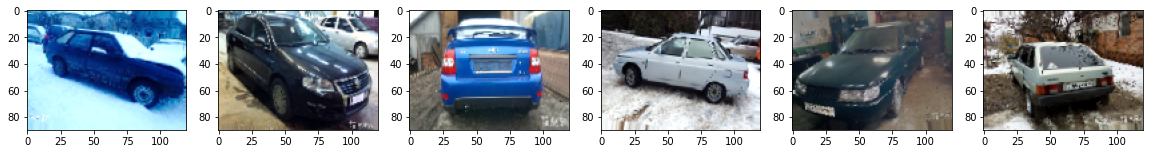

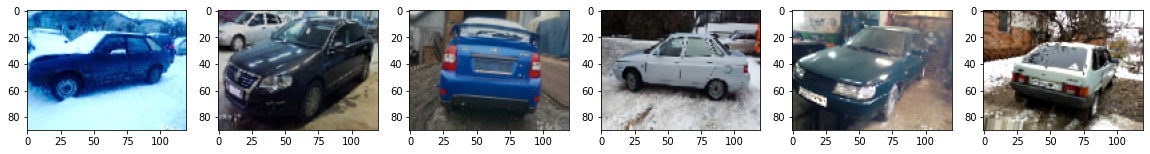

In [ ]:
sub_datagen = ImageDataGenerator(
    #rescale=1/255
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2)
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=(90, 120),
    batch_size=32,
    shuffle=False
)

show_first_images(sub_generator, labels=False)
sub_generator.reset()
show_first_images(sub_generator, labels=False)

Сделаем предсказания 5 раз:

In [ ]:
predictions = []
for _ in range(5):
  predictions.append(model.predict(sub_generator, verbose=1))
  sub_generator.reset()
predictions = np.array(predictions)
predictions.shape

209/209 [==============================] - 45s 213ms/step


(5, 6675, 10)

Нулевая ось - номер попытки, первая ось - номер изображения, вторая ось - номер класса. Теперь нам нужно сделать усреднение по номеру попытки, а затем argmax по номеру класса (не наоборот!):

In [ ]:
final_predictions = predictions.mean(axis=0).argmax(axis=-1)
final_predictions

array([7, 7, 4, ..., 1, 3, 4])

Мы также можем посмотреть насколько совпали предсказания на каждом изображении с разными аугментациями (цвет на изображении означает класс):

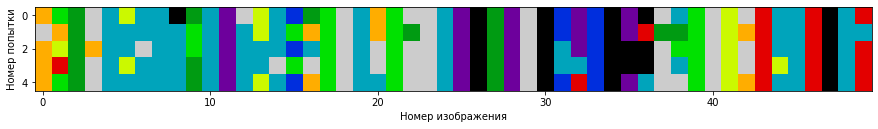

In [ ]:
plt.figure(figsize=(15, 3))
plt.imshow(predictions.argmax(axis=-1)[:, :50], cmap='nipy_spectral')
plt.xlabel('Номер изображения')
plt.ylabel('Номер попытки')
plt.show()

Если же мы делаем аугментации с помощью слоев keras, то можно получить генератор изображений для сабмита таким образом:

Found 6675 validated image filenames.


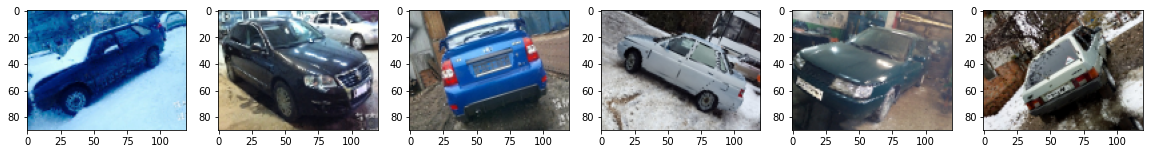

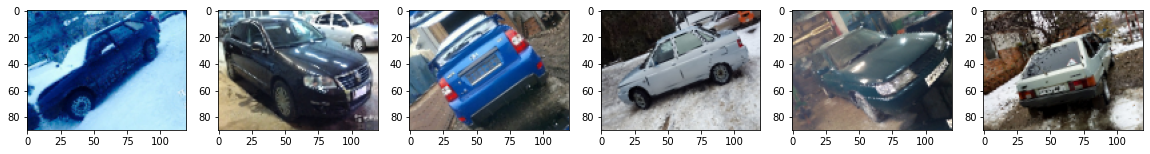

In [ ]:
preprocessing_model = Sequential([
  RandomCrop(90, 120),
  RandomFlip(mode='horizontal'),
  RandomRotation(0.1)
])

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=(90, 120),
    batch_size=32,
    shuffle=False
)

sub_generator_augmented = (preprocessing_model(x, training=True).numpy() for x in sub_generator)

show_first_images(sub_generator_augmented, labels=False)
sub_generator.reset()
show_first_images(sub_generator_augmented, labels=False)

### Ансамблирование

Самый простой способ ансамблирования - усреднение предсказаний нескольких моделей.

Пусть у вас есть три модели:

1.   `model_1` - точность 97.5%
2.   `model_2` - точность 97.2%
3.   `model_3` - точность 97.0%

Посчитаем средневзвешенное среднее предсказаний моделей, отдав больший вес той модели, которая имеет более высокую точность:

In [ ]:
predictions = 0.6*model_1.predict(sub_generator) \
    + 0.25*model_2.predict(sub_generator) \
    + 0.15*model_3.predict(sub_generator)
predictions = predictions.argmax(axis=1)
predictions

array([1, 1, 6, ..., 1, 6, 6])

Скорее всего таким образом удастся увеличить точность предсказаний. В примере выше не использовались TTA, но вы можете их использовать.

Даже не обязательно чтобы сумма весов равнялась единице, важно лишь соотношение весов друг с другом. В самом простом случае можно взять для всех моделей вес 1 - это простое усреднение предсказаний.

Ансамбль можно сделать даже из одной модели, если например взять ее состояния после 10-й, 15-й и 20-й эпох как три разные модели. Это хорошо сочетается с приемом [cyclic learning rate](https://ruder.io/deep-learning-optimization-2017/).

### Получение предсказания модели на изображении

Получить предсказание модели для произвольного изображения можно таким образом:

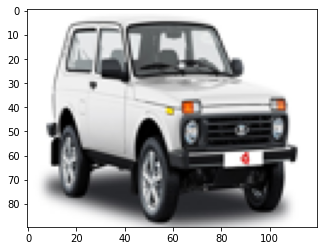

Нива


In [ ]:
# скачиваем изображение по URL
!wget -q https://storage.googleapis.com/oleg-zyablov/skillfactory/car.jpg

#какого размера изображение модель принимает на вход?
img_size = np.array(model.input.shape)[[2, 1]]

# загружаем изображение с помощью cv2
import cv2
image = cv2.imread('car.jpg', cv2.IMREAD_COLOR)[..., ::-1] #cv2.imread читает в формате BGR, конвертируем в RGB с помощью индекса ::-1
image = cv2.resize(image, img_size)

# или загружаем изображение с помощью PIL
from PIL import Image
image = np.array(Image.open('car.jpg').convert('RGB').resize(img_size)) #.convert('RGB') нужен на случай, если изображение черно-белое

plt.imshow(image)
plt.show()

# превращаем изображение в батч из одного изображения, добавляя новую ось в начале
image = image[None, ...]

# делаем нормализацию, если это нужно для нашей модели
# image = image / 255

# получаем батч предсказаний и берем нулевой элемент
pred = model.predict(image)[0]

# берем индекс класса с максимальным значением
class_idx = pred.argmax()

# получаем название
print(class_names[class_idx])

Чем лучше обучена модель - тем больший шанс получения верного ответа.

### Pytorch

Если вы хотите использовать pytorch вместо keras+tensorflow, то ниже приведен краткий код, который вы можете использовать как основу для построения вашего решения.

In [ ]:
#TODO

# Критерии оценивания

Среда выполнения: Kaggle Kernel, Google Colab, локальный ПК и др. - на ваш выбор.

Вы можете использовать любую библиотеку для deep learning, не обязательно keras+tensorflow.

Если у вас есть сомнения по какому-то из пунктов - обратитесь с вопросом заранее, до финальной сдачи проекта.

### **Качество и понятность кода**

По данному пункту сложно дать четкие правила, но старайтесь избегать [следующих](https://www.youtube.com/watch?v=vxXiyPgpT1Y) распространенных проблем:

1. Чрезмерный объем ноутбука. Систематизируйте ваш код: удаляйте лишние ячейки, разбивайте на главы. Исследования данных, неудачные эксперименты выносите в отдельные ноутбуки, чтобы ноутбуки были короче, тогда с ними будет проще работать. Если делаете `.summary()` для больших сверточных сетей, то удаляйте вывод этой ячейки.
2. Плохо читаемый код. Называйте переменные понятными именами, комментируйте код и следуйте стандарту pep-8.
3. Непонятно структурированный код. Например, в коде идет загрузка моделей из файлов, которые ранее нигде не создавались.
4. Выполнение простых вещей сложными способами. Старайтесь делать ваш код лаконичнее, используя библиотечные функции и удобные конструкции языка.

В целом старайтесь следовать своему представлению о качестве и понятности кода. В случае спорных моментов будьте готовы доказать свою точку зрения.

Если вы проделали сложную последовательность действий, которая не может быть умещена в одном ноутбуке, то вы можете написать письменный отчет о выполнении проекта (+код).

**Оценивание: от 0 до 3 баллов.**

### **Метрика качества**

Оценивается по [лидерборду](https://www.kaggle.com/c/sf-dl-car-classification/leaderboard) на Kaggle.

**Оценивание:**

*   **96.5% (~топ 50% участников) - 1 балл**
*   **96.8% (~топ 30% участников) - 2 балла**
*   **97.4% (~топ 15% участников) - 3 балла**
*   **Больше 97.4% - по 1 бонусному баллу за 0.05%**

### **Работа с обучающими данными**

Проведите несколько экспериментов с разными аугментациями изображений, выберите оптимальные аугментации на основе чего-то из перечисленного:

1. Точность на валидационной выборке или сабмите
2. Научные статьи и статьи из интернета

Всегда проверяйте аугментации визуально, отрисовывая изображения.

**Оценивание: от 0 до 3 баллов.**

**Можно получить 2 бонусных балла** за использование при обучении внешних датасетов (в т. ч. собранных вами).

**Можно получить от 1 бонусного балла и выше** за реализацию *автоматической* очистки обучающих данных, то есть удаления некорректных данных. Например вы можете использовать обученную на imagenet сеть для определения того, присутствует ли автомобиль на изображении.

### **Работа с архитектурой модели**

Проведите несколько экспериментов с разными архитектурами моделей, выберите оптимальную архитектуру (или несколько архитектур) на основе чего-то из перечисленного:

1. Точность на валидационной выборке или сабмите
2. Научные статьи и статьи из интернета

**Оценивание: от 0 до 3 баллов.**

**Можно получить от 2 бонусных баллов и выше** за использование при обучении моделей не из модуля `keras.applications` (найдите такие модели и способ их использовать, [пример](https://www.kaggle.com/olegzyablov/notebook31bc947a7f)).

### **Работа с процессом обучения**

Проведите несколько экспериментов с разными оптимизаторами, learning rate и (опционально) продвинутыми техниками, такими как постепенная разморозка слоев, progressive resizing или изменение степени аугментаций при обучении. Выберите оптимальный вариант на основе чего-то из перечисленного:

1. Точность на валидационной выборке или сабмите
2. Научные статьи и статьи из интернета

**Оценивание: от 0 до 3 баллов.**

**Можно получить 2 бонусных балла** за использование какой-то из перечисленных выше продвинутых техник и демонстрации (убедительного доказательства) того, что использование этой техники повышает качество обучения модели, либо доказательства обратного.

**Можно получить 1 бонусный балл** за использование техники pseudo-labeling (псевдо-разметки датасета для сабмита) и демонстрации того, что она повышает качество обучения модели.

### **Работа с процессом инференса**

Инференсом называется получение предсказаний модели на данных.

Делайте ансамблирование и TTA с целью улучшить точность предсказаний. Всегда проверяйте, насколько улучшилась (и улучшилась ли) точность от использования ансамблирования и TTA.

**Оценивание: от 0 до 3 баллов.**

**Можно получить 1 бонусный балл** за детальный анализ предсказаний модели. Проверьте на каких моделях автомобилей нейросеть чаще всего ошибается, постройте confusion matrix, сделайте из этого какие-то выводы.

**Можно получить 1-2 бонусных балла** за корректно реализованное ансамблирование, более сложное, чем простое усреднение. Например вы можете реализовать бэггинг или стакинг. В случае стакинга можно использовать метод опорных векторов. Обязательно проверьте, как ансамблирование сказывается на метрике качества.

### **Создание работающего прототипа**

Реализуйте один из вариантов:
1. Веб-сервер, принимающий изображение (можно по URL) и возвращающий название модели автомобиля
2. Скрипт .py, который печатает название модели автомобиля, присутствующего на выбранном изображении

**Оценивание: от 0 до 3 баллов.**

Срок сдачи проекта не влияет на оценивание.

# Правила сдачи работы

Работа сдается через платформу [lms.skillfactory.ru](https://lms.skillfactory.ru) на странице проекта Ford vs Ferrari.

**Вариант 1.** Ссылка на ноутбук на Kaggle. Если ваш ноутбук приватный, то **откройте к нему доступ** для [проверяющего ментора](https://www.kaggle.com/olegzyablov).

**Вариант 2.** Ссылка на Google Colab или другой ресурс, с которого можно скачать ноутбук с кодом. Не забудьте проверить, что ссылка работает и к ноутбуку **открыт доступ**. Также **укажите ваш никнейм на Kaggle**, чтобы можно было найти вас в лидерборде.

По желанию укажите предпочитаемый способ связи с вами (Slack, Telegram, ...).

По результатам оценивания возможна апелляция, для этого напишите мне в Slack (Oleg Zyablov) или Telegram (@olegz1339).

Проект **можно сдавать более одного раза**. Это означает, что вы сдаете проект, узнаете свои текущие баллы, дорабатываете проект и сдаете повторно. При повторной сдаче **указывайте что именно вы изменили в коде**, чтобы не приходилось заново просматривать весь ноутбук. И просьба не злоупотреблять, так как каждая повторная проверка занимает время.

Вы можете задавать любые вопросы по проекту в Slack в соответствующий канал.